In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as XGB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

from sets import Set
import math
%matplotlib inline


In [2]:
def years_since_built(df):
    df["YearSinceBuilt"] = df["YrSold"] - df["YearBuilt"]


In [3]:
def years_since_remodAdd(df):
    df["YearSinceRemodAdd"] = df["YrSold"] - df["YearRemodAdd"]

In [4]:
def compute_years_and_was_remodAdd(df):
    years_since_remodAdd(df)
    def check_remodAdd (row):
        if row['YearSinceRemodAdd'] > 0 :
            return '1'
        return '0'
    df["wasRemodAdd"] = df.apply (lambda row: check_remodAdd (row),axis=1).astype(int)


In [5]:
def create_total_sf(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] 
    

In [6]:
def standardize_numerical_features(df,feature_list):
    for feature in feature_list:
        feature_series= df.loc[:,feature]
        df.loc[:,feature] = (feature_series - feature_series.mean())/feature_series.std()

In [7]:
def one_hot_categorical(df,categorical_features):
    dummy_variables = []
    for feature in categorical_features:
        one_hot = pd.get_dummies(df[[feature]].astype(str))
        dummy_variables.extend(list(one_hot))
        df = pd.concat([df, one_hot], axis=1)
    return df, dummy_variables

In [8]:
def has_basement(all_data):
    all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
    all_data['HasBsmt'] = 0 
    all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1

In [371]:
#Loading data
all_data = pd.read_csv('train.csv')

#Declaring features
numerical_features = ['TotalSF',"GrLivArea",'YearSinceRemodAdd','YearSinceBuilt','TotRmsAbvGrd', 'GarageCars',
                      'OverallGrade','TotalBath','LotArea','ExterCond','HeatingQC','BsmtExposure','Fence']
categorical_features = ['MSSubClass','MSZoning','Street','LotShape','MasVnrType','SaleCondition','SaleType']
binary_features = ['wasRemodAdd','HasBsmt','HighSeason','Neighborhood_Good']
#feature engineering

create_total_sf(all_data)
years_since_built(all_data)
compute_years_and_was_remodAdd(all_data)
has_basement(all_data)

all_data = all_data.replace({"ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}
                       }
                     )

all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]


all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])


all_data['TotalSF'] = np.log(all_data['TotalSF'])
all_data.loc[(all_data["MasVnrType"].isnull()), "MasVnrType"] = 'None'

all_data['LotArea'] = all_data['LotArea']**2

all_data["BsmtExposure"] = all_data["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)
all_data["Fence"] = all_data["Fence"].map({None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
all_data["HighSeason"] = all_data["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

all_data.loc[all_data.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
all_data["Neighborhood_Good"].fillna(0, inplace=True)


standardize_numerical_features(all_data,numerical_features)
all_data, dummy_variables = one_hot_categorical(all_data,categorical_features)

all_data.drop(['MSZoning_C (all)','MSSubClass_160'],axis=1)

#splitting data
features = numerical_features + dummy_variables + binary_features
y = np.log(all_data.pop('SalePrice'))
X = all_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,
                                                    stratify=all_data[categorical_features])


In [378]:
#train model
estimator = XGB.XGBRegressor(seed=42, max_depth=4, n_estimators=200, learning_rate = 0.1,gamma=4)
model = estimator.fit(X_train,y_train)
print math.sqrt((mean_squared_error(y_test, model.predict(X_test))))
print (model)



0.168566481414
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=4,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)


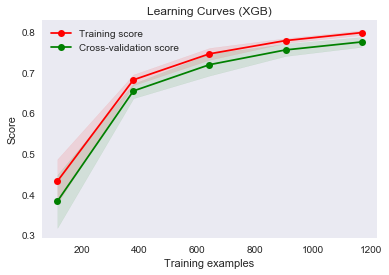

In [379]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

title = "Learning Curves (XGB)"
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
   estimator, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")



In [380]:
#train model on all data
model = estimator.fit(X,y)

#Test evaluation
#Loading data
all_data = pd.read_csv('test.csv')


#Declaring features
numerical_features = ['TotalSF',"GrLivArea",'YearSinceRemodAdd','YearSinceBuilt','TotRmsAbvGrd', 'GarageCars',
                      'OverallGrade','TotalBath','LotArea','ExterCond','HeatingQC','BsmtExposure','Fence']
categorical_features = ['MSSubClass','MSZoning','Street','LotShape','MasVnrType','SaleCondition','SaleType']
binary_features = ['wasRemodAdd','HasBsmt','HighSeason','Neighborhood_Good']
#feature engineering

create_total_sf(all_data)
years_since_built(all_data)
compute_years_and_was_remodAdd(all_data)
has_basement(all_data)

all_data = all_data.replace({"ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}
                       }
                     )

all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]


all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])


all_data['TotalSF'] = np.log(all_data['TotalSF'])
all_data.loc[(all_data["MasVnrType"].isnull()), "MasVnrType"] = 'None'

all_data['LotArea'] = all_data['LotArea']**2

all_data["BsmtExposure"] = all_data["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)
all_data["Fence"] = all_data["Fence"].map({None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
all_data["HighSeason"] = all_data["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

all_data.loc[all_data.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
all_data.loc[all_data.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
all_data["Neighborhood_Good"].fillna(0, inplace=True)


standardize_numerical_features(all_data,numerical_features)
all_data, dummy_variables = one_hot_categorical(all_data,categorical_features)

all_data.drop(['MSZoning_C (all)','MSSubClass_160'],axis=1)

#splitting data
X = all_data[features]

#predicting
all_data['SalePrice'] = np.exp(model.predict(X))
all_data.loc[:,['Id','SalePrice']].to_csv('result.csv', header=True,index=False)